In [1]:
from tgp.experiments import get_dataset
import GPyOpt
import numpy as np
%matplotlib inline

In [2]:
df = get_dataset()

In [3]:
# We can also use tgp.experiments.get_single_matern to do
# some of the work in this demo notebook. But here we show the full
# sequence of steps to optimise a problem.

In [4]:
# First, we define our kernel.
from tgp.matern_kernels import MaternKernel32

In [5]:
# To do optimisation, we'll need a function that creates a kernel.
def get_kernel(theta):
    kernel = MaternKernel32(np.array([theta[0]]), theta[1])
    return kernel

In [6]:
# We'll also need some bounds to search in:
bounds = [{'name': 'l', 'type': 'continuous', 'domain': (0.1, 10.)},
          {'name': 'sd', 'type': 'continuous', 'domain': (0.01, 2.)}]


In [7]:
# Now, let's get our data
# Use 2016 & 2017 to optimise
df = df.query("""
    start_date >= "2016-1-1" & start_date < "2017-12-31"
""")

winners = df['winner'].values
losers = df['loser'].values
days_since_start = (df['start_date'] - df['start_date'].min()).dt.days.values

In [8]:
from tgp.gp_predictor import GPPredictor

In [16]:
# We need a function we can minimise using GPy. 
# Let's define that here.
def to_minimise(theta, unwrap=True):
    
    if unwrap:
        # GPy has an extra level of wrapping for some reason
        theta = theta[0]
    
    # Get our kernel
    kernel = get_kernel(theta)
    
    # Fit the model
    predictor = GPPredictor(kernel)
    predictor.fit(winners, losers, days_since_start)
    
    # Now we can calculate the log marginal likelihood
    log_marginal_lik = predictor.calculate_log_marg_lik()
    
    print(f'Negative log marginal likelihood for lengthscale {theta[0]:.2f}'
          f' and sd {theta[1]:.2f} is {-log_marginal_lik:.2f}')
    
    # Return it with its sign flipped so we can _minimise_
    return -log_marginal_lik

In [17]:
# At this point, we can use any minimisation routine (e.g. random search).

# Now we can define a GPy "problem"
# Note: this automatically runs 5 initial runs.
problem = GPyOpt.methods.BayesianOptimization(to_minimise, bounds)

Negative log marginal likelihood for lengthscale 4.92 and sd 1.83 is 13175.59
Negative log marginal likelihood for lengthscale 4.63 and sd 0.66 is 13126.87
Negative log marginal likelihood for lengthscale 4.97 and sd 1.45 is 13144.39
Negative log marginal likelihood for lengthscale 1.24 and sd 1.98 is 13254.45
Negative log marginal likelihood for lengthscale 1.82 and sd 0.59 is 13146.16


In [18]:
# Run a further 10 times
problem.run_optimization(10)

Negative log marginal likelihood for lengthscale 5.28 and sd 0.72 is 13121.41
Negative log marginal likelihood for lengthscale 2.92 and sd 0.01 is 13471.98
Negative log marginal likelihood for lengthscale 1.09 and sd 0.43 is 13206.93
Negative log marginal likelihood for lengthscale 5.12 and sd 0.06 is 13446.67
Negative log marginal likelihood for lengthscale 4.99 and sd 0.87 is 13116.81
Negative log marginal likelihood for lengthscale 5.42 and sd 1.05 is 13120.07
Negative log marginal likelihood for lengthscale 4.41 and sd 1.04 is 13120.32
Negative log marginal likelihood for lengthscale 6.22 and sd 0.95 is 13117.42
Negative log marginal likelihood for lengthscale 6.57 and sd 1.54 is 13149.69
Negative log marginal likelihood for lengthscale 6.93 and sd 0.74 is 13120.65


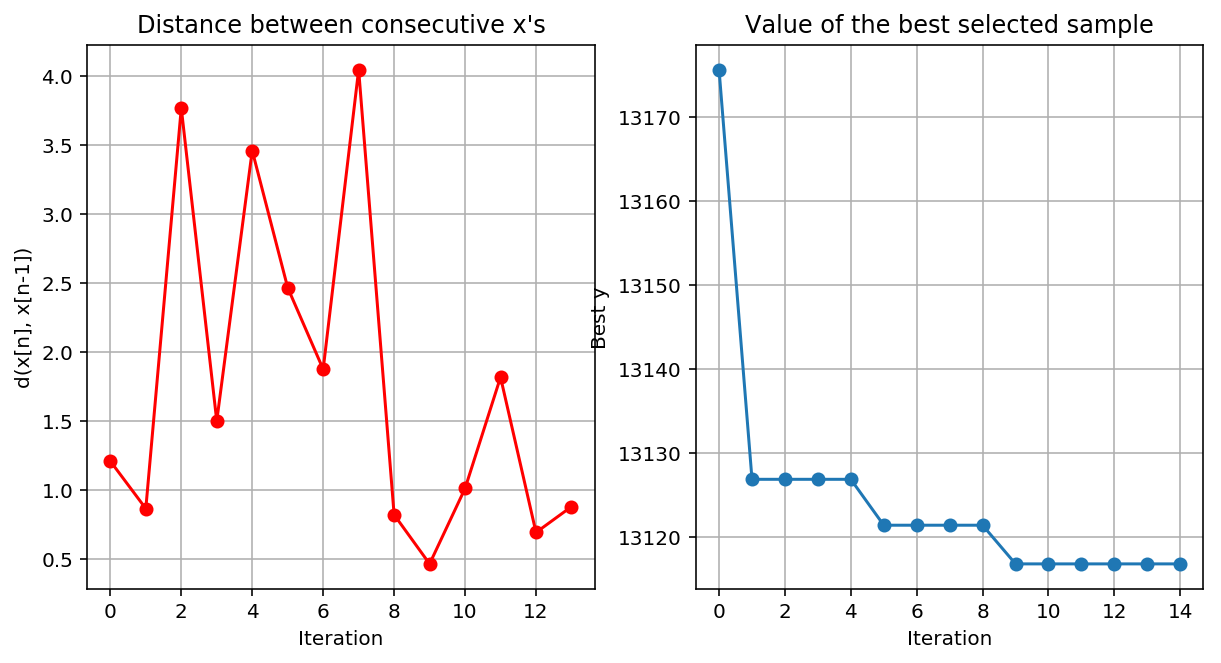

In [19]:
# We can take a look at the convergence results
problem.plot_convergence()

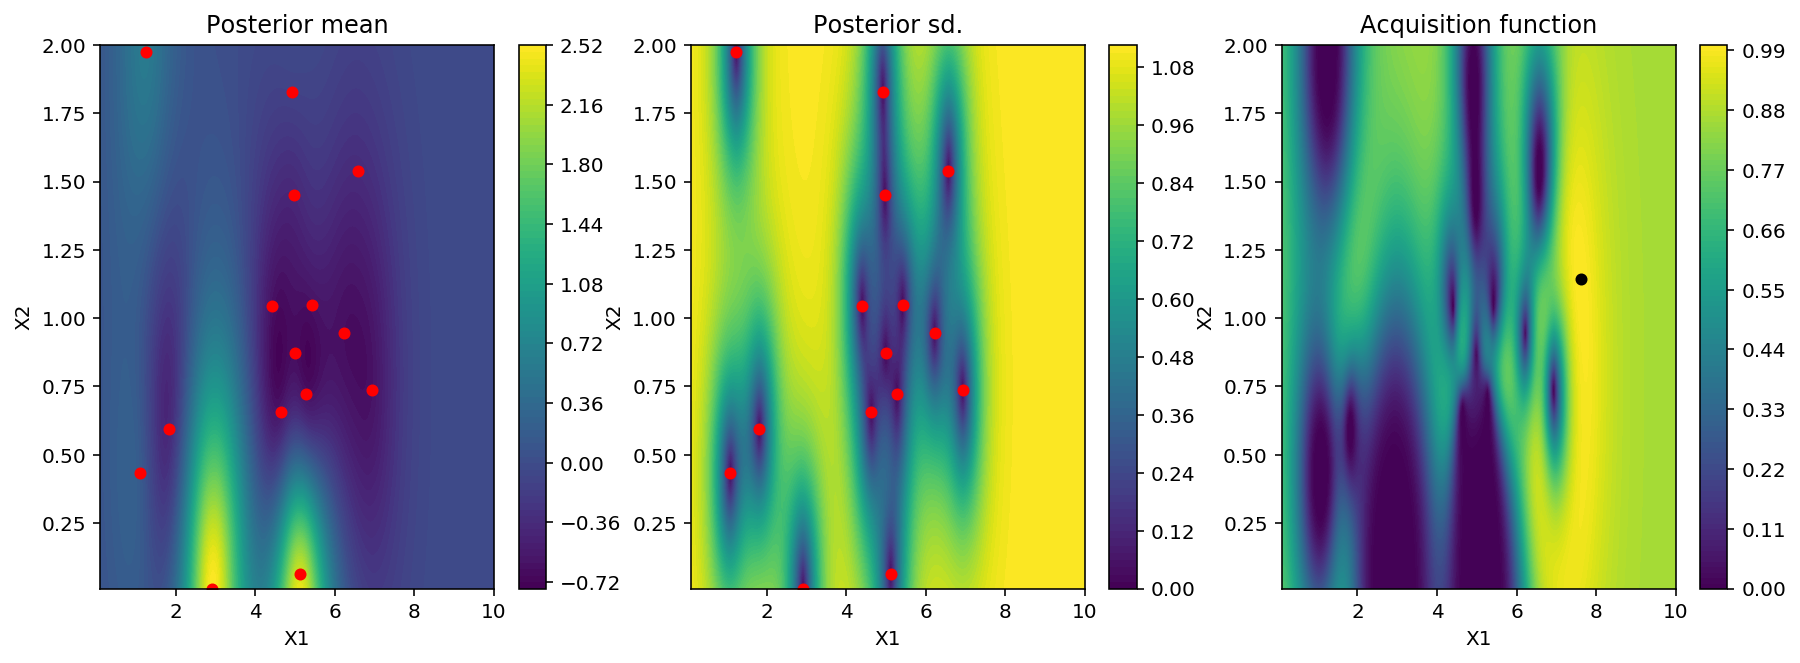

In [20]:
# We can also take a look at what the inferred loss surface looks like
# (at least for this 2D example)
problem.plot_acquisition()

In [21]:
# We can get the best x found
problem.x_opt

array([4.9903672 , 0.87167877])

In [22]:
# And the best function value:
problem.fx_opt

13116.805033428878